# Manifolds

In [1]:
%load_ext autoreload
%autoreload 2
import latenta as la
import lacell as lac
import numpy as np

We'll use the same dataset as [before](./1-variables)

In [2]:
adata = la.data.load_myod1()

In [3]:
import scanpy as sc

adata.raw = adata

sc.pp.normalize_per_cell(adata)
sc.pp.log1p(adata)

sc.pp.combat(adata)
sc.pp.pca(adata)

sc.pp.neighbors(adata)
sc.tl.umap(adata)

adata.obs["log_overexpression"] = np.log1p(adata.obs["overexpression"])

/home/wsaelens/projects/probabilistic-cell/.venv/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'dissociation' as categorical
/home/wsaelens/projects/probabilistic-cell/.venv/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'gene_overexpressed' as categorical
/home/wsaelens/projects/probabilistic-cell/.venv/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas

So far, we have focused on models that basically look like this:

![](_static/previous.svg)

But what if our cellular variables are also unknown, i.e. latent?

![](_static/now.svg)

In this case, apart from learning a latent space about genes, we _at the same time_ also try to learn a latent space on cells, also known as the "cellular manifold". There are many different ways to represent this manifold, and how to do this depends on what we know about the cells and what we try to accomplish:

- **embedding**: Each cell is placed in an n-dimensional space, with only a few restrictions, such as the cell positions are all centered around 0. This space is very flexible, but not interpretable. Essentially, it is only interpretable when converted to a 2D representation and viewed by the human eye. Related to this, this space is typically far removed from biological reality. A cell's state does not "float" in an n-dimensional space.
- **scalar** (differentiation, cell cycle, ...): Each cell is placed in a one-dimensional space, with a single pseudotime.

While many manifold models are relatively easy to implement, the main difficulty lies in the interpretability. Especially when different **cellular processes** are happening at the same time in a cell, a single latent variable will typically try to explain all of them. What is therefore often required is the inclusion of prior knowledge that can help with disentangling different cellular processes.

## Differentiation: Inferring a dominant scalar latent variable

Just by looking at the 2D representation, it's clear that there are two dominant processes going on in the cell: differentiation (in this case to myocytes) and the cell cycle. On top of that, it seems that there is some heterogeneity in the control cells, although the magnitude of this is difficult to determine based on a 2D representation.

In [4]:
cellcycle_genes = lac.cell.cellcycle.get_cellcycle_genes()
sc.tl.score_genes_cell_cycle(
    adata,
    s_genes=cellcycle_genes.query("phase == 'S'")["gene"].tolist(),
    g2m_genes=cellcycle_genes.query("phase == 'G2/M'")["gene"].tolist(),
)

/home/wsaelens/projects/probabilistic-cell/.venv/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'phase' as categorical


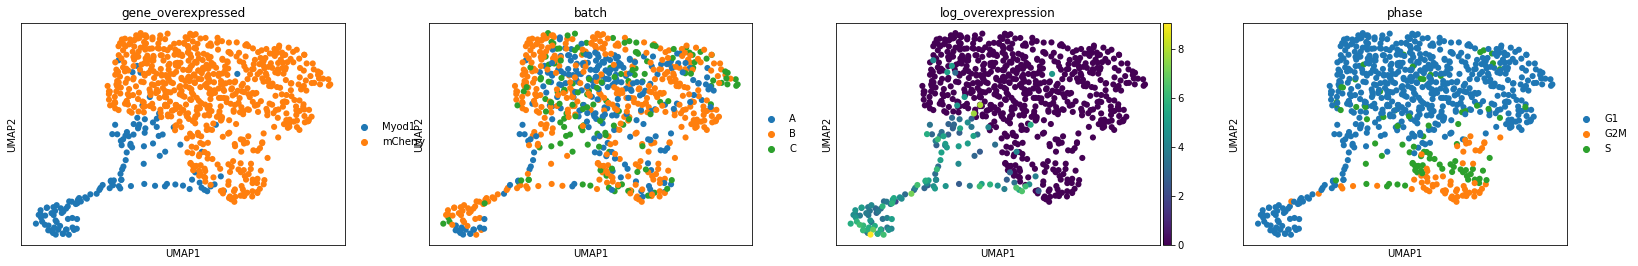

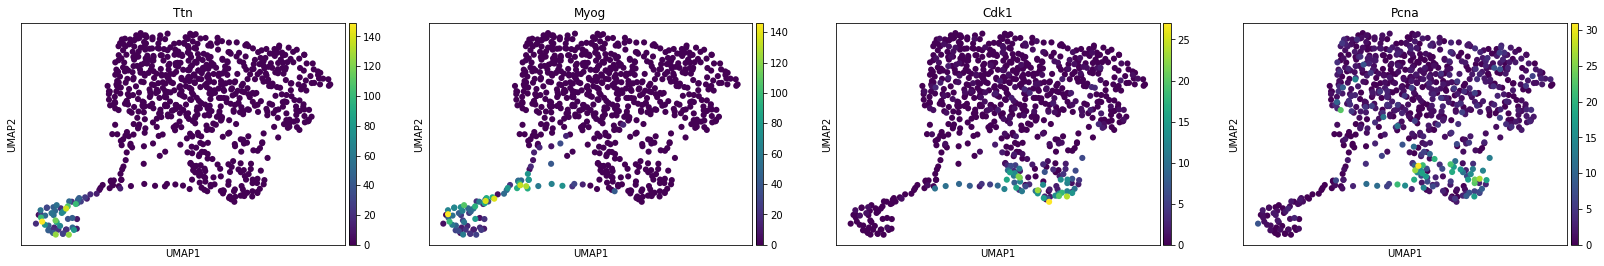

In [5]:
symbols = ["Ttn", "Myog", "Cdk1", "Pcna"]
sc.pl.umap(adata, color=["gene_overexpressed", "batch", "log_overexpression", "phase"])
sc.pl.umap(
    adata, color=adata.var.set_index("symbol").loc[symbols]["ens_id"], title=symbols
)

For illustration purposes, we will first remove (or reduce) the effect of the cell cycle by removing the cycling cells.

In [6]:
adata_oi = adata[adata.obs["phase"] == "G1"].copy()

In [7]:
transcriptome = lac.transcriptome.Transcriptome.from_adata(adata_oi)

We define the differentiation as a _scalar_ latent variable, that assigns to each cell one value. This single value in our case is again modelled as a latent variable, with both a prior and variational distribution, the latter capturing it uncertainty.

Crucial here is that we provide an appropriate prior distribution. Given that we assume that differentiation has a start and an end, we want to place the cells somewhere in the  $[0, 1]$ interval. A uniform distribution is therefore most appropriate. Do note that other cellular processes may have other assumptions or hypotheses, and will therefore require different priors as we will see later.

In [8]:
differentiation = la.Latent(
    la.distributions.Uniform(),
    definition=[transcriptome["cell"]],
    label="differentiation",
)

Now that we have defined the cellular latent space, we still have to define how this space affects the transcriptome. We typically choose a spline function for this, as this is a flexible but smooth function.

In [9]:
foldchange = transcriptome.find("foldchange")
foldchange.differentiation = la.links.scalar.Spline(
    differentiation, output=foldchange.value_definition
)

:::{note}

Although a spline function is flexible, like always we do still make some assumptions, namely:
- The outcome is smooth, without a lot of sudden jumps.
- The flexibility is limited by the number of knots. There is a trade-off here, as more knots will mean more flexibility but also more chances of overfitting.

:::

As before, we also want to correct for the batch effect:

In [10]:
batch = la.variables.discrete.DiscreteFixed(adata_oi.obs["batch"])
foldchange.batch = la.links.vector.Matmul(batch, output=foldchange.value_definition)

In [11]:
foldchange.plot()

  0%|                                                                                                         …

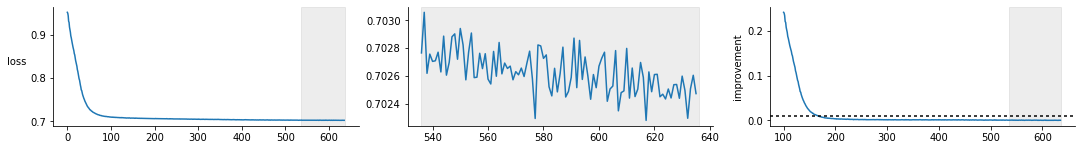

In [12]:
with transcriptome.switch("cuda"):
    inference = la.infer.svi.SVI(
        transcriptome, [la.infer.loss.ELBO()], la.infer.optim.Adam(lr=0.05)
    )
    trainer = la.infer.trainer.Trainer(inference)
    trace = trainer.train(10000)
    trace.plot()

To extract the inferred values from the

In [13]:
differentiation_observed = la.posterior.scalar.ScalarObserved(differentiation)
differentiation_observed.sample(10)

  0%|          | 0/10 [00:00<?, ?it/s]

<AxesSubplot:xlabel='differentiation', ylabel='Count'>

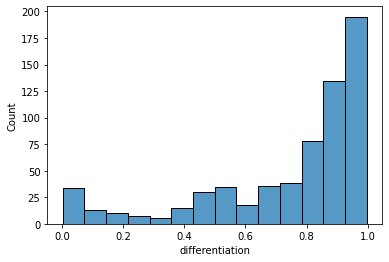

In [14]:
differentiation_observed.plot()

In [15]:
adata_oi.obs["differentiation"] = differentiation_observed.mean.to_pandas()

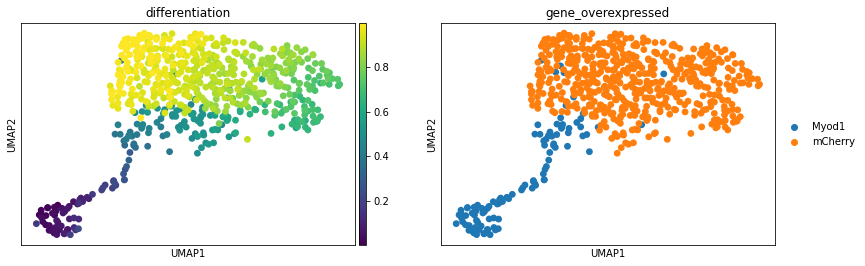

In [16]:
sc.pl.umap(adata_oi, color=["differentiation", "gene_overexpressed"])

Even though the differentiation is very dominant, the model still used about half of the latent space to explain some heterogeneity in the control cells.

## Differentiation: Providing a little bit of prior knowledge

In this case, we can easily fix this by including some external information. Namely, we know which cells were not perturbed, and we can therefore _nudge_ the differentiation values of those cells close to 0 by specifying an appropriate prior distribution.

In [17]:
transcriptome = lac.transcriptome.Transcriptome.from_adata(adata_oi)

In [18]:
# gene_overexpressed = la.variables.DiscreteFixed(adata_oi.obs["gene_overexpressed"])

In [19]:
# alpha_go = la.Fixed(pd.Series([1., 1.], index = adata_oi.obs["gene_overexpressed"].cat.categories), label = "alpha")
# beta_go = la.Fixed(pd.Series([1., 100.], index = adata_oi.obs["gene_overexpressed"].cat.categories), label = "beta")

In [20]:
import pandas as pd

differentiation_p = la.distributions.Beta(
    beta=la.Fixed(
        pd.Series([1.0, 100.0], index=["Myod1", "mCherry"])[
            adata_oi.obs["gene_overexpressed"]
        ].values,
        definition=[transcriptome["cell"]],
    ),
    alpha=la.Fixed(
        pd.Series([1.0, 1.0], index=["Myod1", "mCherry"])[
            adata_oi.obs["gene_overexpressed"]
        ].values,
        definition=[transcriptome["cell"]],
    ),
)

Note that we do not place a hard prior on these differentiation values, and that control cells can therefore still have high differentiation if this is really supported by the data.

In [21]:
differentiation = la.Latent(
    differentiation_p, definition=[transcriptome["cell"]], label="differentiation"
)

In [22]:
differentiation.plot()

In [23]:
foldchange = transcriptome.find("foldchange")

In [24]:
foldchange.differentiation = la.links.scalar.Spline(
    differentiation, output=foldchange.value_definition
)

In [25]:
batch = la.variables.discrete.DiscreteFixed(adata_oi.obs["batch"])
foldchange.batch = la.links.vector.Matmul(batch, output=foldchange.value_definition)

In [26]:
foldchange.plot()

  0%|                                                                                                         …

  0%|                                                                                                         …

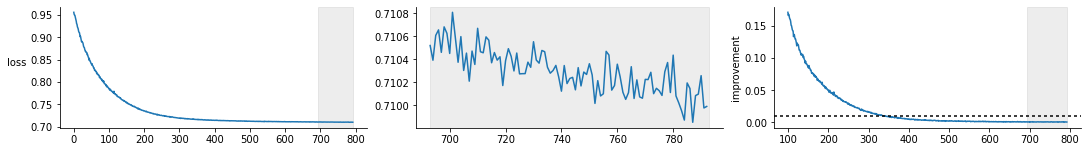

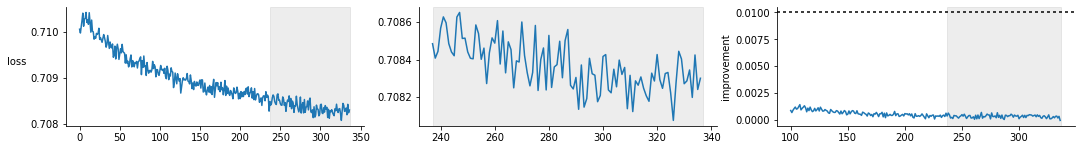

In [27]:
with transcriptome.switch("cuda"):
    inference = la.infer.svi.SVI(
        transcriptome, [la.infer.loss.ELBO()], la.infer.optim.Adam(lr=0.01)
    )
    trainer = la.infer.trainer.Trainer(inference)
    trace = trainer.train(10000)
    trace.plot()

    inference = la.infer.svi.SVI(
        transcriptome, [la.infer.loss.ELBO()], la.infer.optim.Adam(lr=0.01)
    )
    trainer = la.infer.trainer.Trainer(inference)
    trace = trainer.train(10000)
    trace.plot()

In [28]:
differentiation_observed = la.posterior.scalar.ScalarObserved(differentiation)
differentiation_observed.sample(10)

  0%|          | 0/10 [00:00<?, ?it/s]

In [29]:
adata_oi.obs["differentiation"] = differentiation_observed.mean.to_pandas()

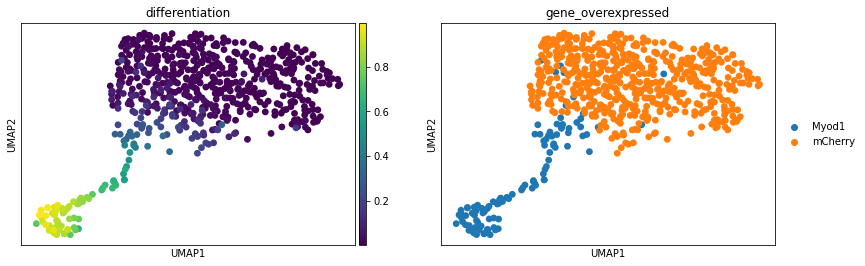

In [30]:
sc.pl.umap(adata_oi, color=["differentiation", "gene_overexpressed"])

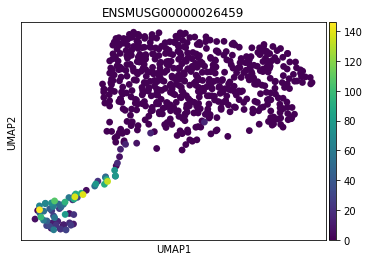

In [31]:
sc.pl.umap(
    adata_oi, color=adata.var.reset_index().set_index("symbol").loc[["Myog"]].gene
)

In [32]:
differentiation_causal = la.posterior.scalar.ScalarVectorCausal(
    differentiation,
    transcriptome,
    observed=differentiation_observed,
    interpretable=transcriptome.p.mu.expression,
)
differentiation_causal.sample(10)

  0%|          | 0/10 [00:00<?, ?it/s]

This posterior also contains samples, but now for some pseudocells with each a distinct value for the `overexpression` variable.

Depending on the type of causal posterior, you can plot the outcome. The {class}`~latenta.posterior.scalar.ScalarVectorCausal` can for example plot each individual _feature_ across all cells (in this case gene):

In [33]:
differentiation_causal.sample_empirical()
differentiation_causal.sample_random()

  0%|          | 0/10 [00:00<?, ?it/s]

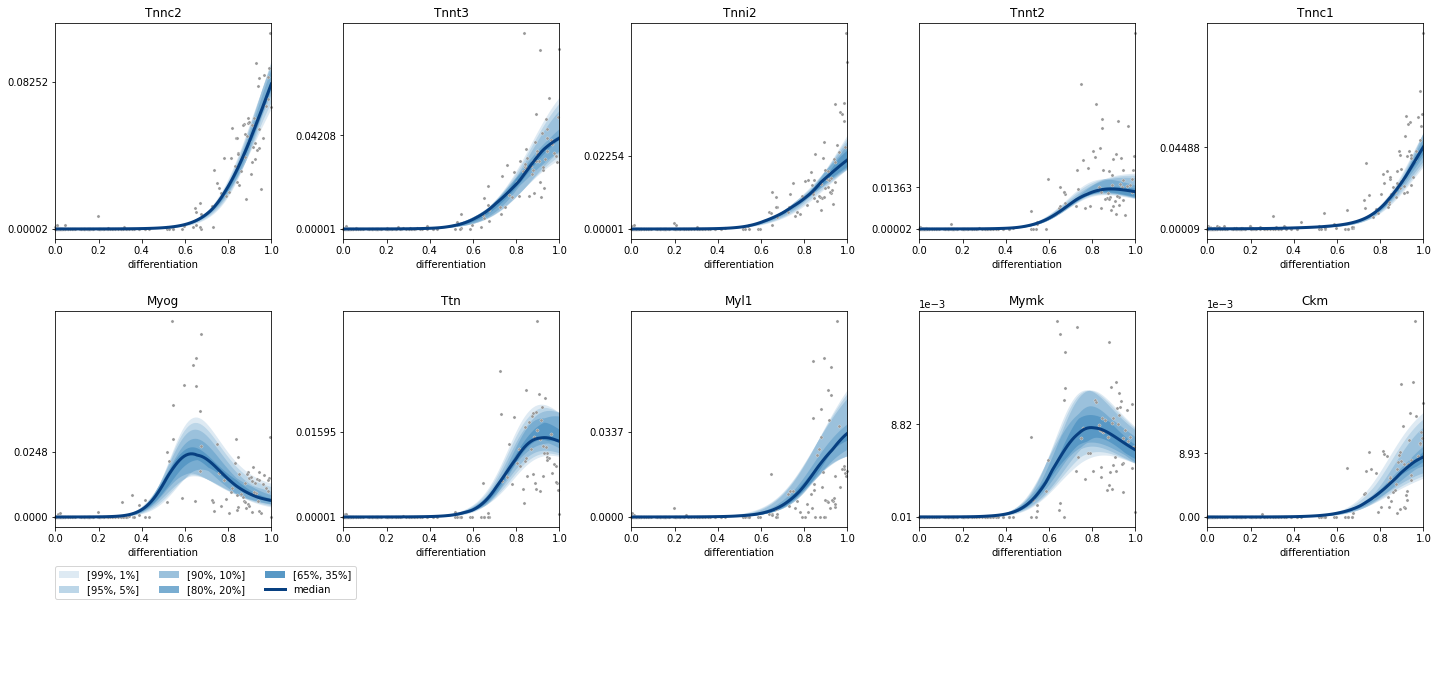

In [34]:
differentiation_causal.plot_features();

## Differentiation: increasing scalability and robustness through amortization

Because the model has to infer both cell- and gene-specific latent variables at the same time, finding a robust solution for this model be tricky. One reason for this is that that during optimization, both groups of latent variables have to follow eachother, and they can easily get stuck together in suboptimal solutions. Indeed, if you would run the above model a couple of times, you will see that sometimes the inferred differentiation values are completely different.

One main way to make inference of a latent space more robust is to not directly infer the latent variables for each cell individually, but instead train a _amortization function_ that provides this latent space for us. This function will typically use our observation, in this case the transcriptome's count matrix, and predict the components of the variational distribution, i.e. $\mu$ and $\sigma$. We of course still have to train some parameters, namely the parameters of this amortization function, but this makes training much easier as information is shared between all cells.

The main challenge with amortization is that we need to choose a function that is extremely flexible, as it needs to combine information coming from all genes into a probably highly non-linear model. We therefore typically choose a neural network. The number of layers of this function depends on the complexity of the data. More specifically, how all features in the observation are related. A transcriptomics count matrix has fairly simple "co-expression" structure and therefore typically on requires two layers. The pixels and channels in imaging data on the other hand have a more intracate and hierarchical structure that is best captured by many layers (i.e. deep learning).

:::{note}

Don't we lose interpretability if we use this neural network?

It's certainly true that a neural network, even of a small size, can be very difficult to interpret. At best, we may be able to rank some genes according to their importance in the model. However, in our case we don't really care about this interpretability, because amortization is just a trick to make inference easier. It's important to remember that the actual interpretability always lies downstream from the variational distribution, in how the cellular latent space is related to the transcriptome. The amortization function just helps us to estimate the variational distribution, but doesn't help us with explaining the transcriptome. For a variational distribution, we therefore only want accuracy and ease of inference, which neural networks can provide, but not interpretability.

:::

In [35]:
transcriptome = lac.transcriptome.Transcriptome.from_adata(adata_oi)

In [36]:
differentiation = la.Latent(
    differentiation_p, definition=[transcriptome["cell"]], label="differentiation"
)

In [37]:
encoder = la.amortization.Encoder(
    la.Fixed(transcriptome.loader, definition=transcriptome),
    differentiation,
    pretrain=False,
    lr=1e-3,
)

In [38]:
differentiation.plot()

In [39]:
foldchange = transcriptome.find("foldchange")

In [40]:
foldchange.differentiation = la.links.scalar.Spline(
    differentiation, output=foldchange.value_definition
)

In [41]:
batch = la.variables.discrete.DiscreteFixed(adata_oi.obs["batch"])
foldchange.batch = la.links.vector.Matmul(batch, output=foldchange.value_definition)

In [42]:
foldchange.plot()

  0%|                                                                                                         …

  0%|                                                                                                         …

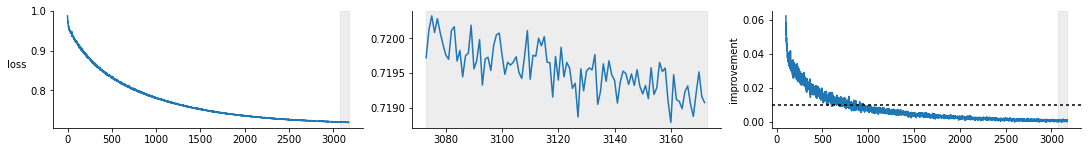

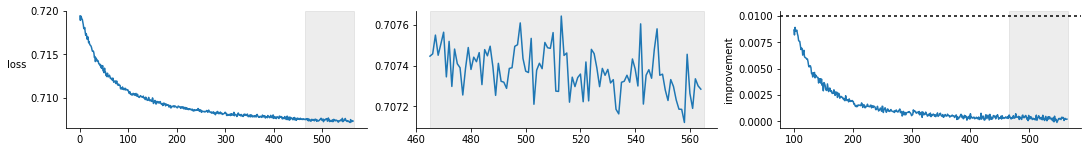

In [43]:
with transcriptome.switch("cuda"):
    inference = la.infer.svi.SVI(
        transcriptome, [la.infer.loss.ELBO()], la.infer.optim.Adam(lr=1e-3)
    )
    trainer = la.infer.trainer.Trainer(inference)
    trace = trainer.train(10000)
    trace.plot()

    inference = la.infer.svi.SVI(
        transcriptome, [la.infer.loss.ELBO()], la.infer.optim.Adam(lr=1e-2)
    )
    trainer = la.infer.trainer.Trainer(inference)
    trace = trainer.train(10000)
    trace.plot()

In [44]:
differentiation_observed = la.posterior.scalar.ScalarObserved(differentiation)
differentiation_observed.sample(10)

  0%|          | 0/10 [00:00<?, ?it/s]

In [45]:
adata_oi.obs["differentiation"] = differentiation_observed.mean.to_pandas()

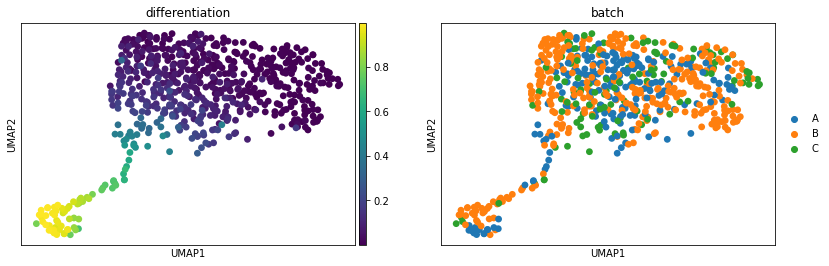

In [46]:
sc.pl.umap(adata_oi, color=["differentiation", "batch"])

In [47]:
differentiation_causal = la.posterior.scalar.ScalarVectorCausal(
    differentiation,
    transcriptome,
    observed=differentiation_observed,
    interpretable=transcriptome.p.mu.expression,
)
differentiation_causal.sample(30)
differentiation_causal.sample_empirical()
differentiation_causal.sample_random()

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

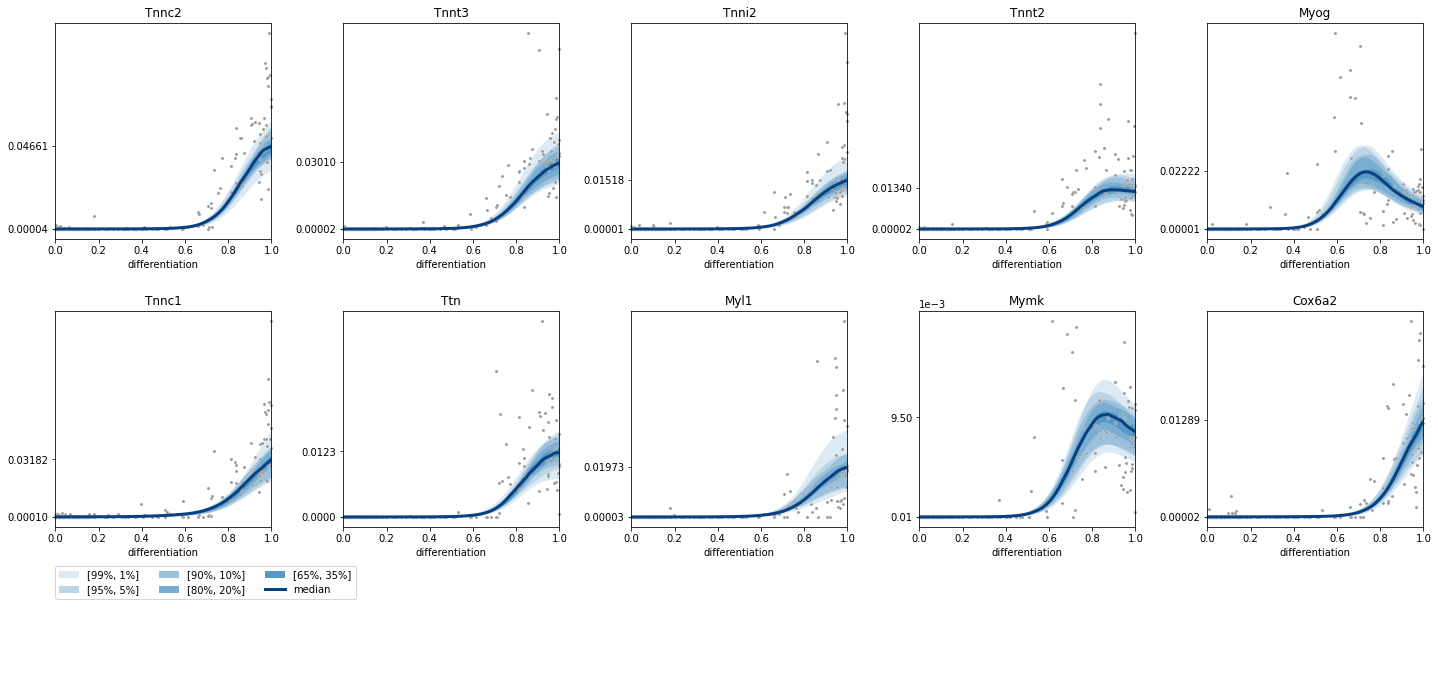

In [48]:
differentiation_causal.plot_features();

Apart from a more robust training, amortization also has a couple of additional advantages:
- Scalability, because we no longer train the variational distribution's parameters for each individual cell, which can easily go into hundreds of thousands to millions. Instead, we only infer a few dozen to a few hundred hundred parameters of the neural network.
- We get a function that can predict the latent space even on unseen cells "for free". Note however, that this does not necessarily mean that our function is generalizable, as this may depend on the assumptions, hyperparameters and structure of the neural network.

## Cell cycle: Including quite some prior knowledge

![](https://cdn.zmescience.com/wp-content/uploads/2018/10/giraffe-661648_960_720.jpg)